In [6]:
import gym
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
from collections import deque

env = gym.make("LunarLander-v2")

In [7]:
L1 = 8
L2 = 64
L3 = 64
L4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3, L4)
)

loss_fn = torch.nn.MSELoss()
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

episode = 2000
gamma = 0.99
eps_start=1.0
eps_end=0.01
eps_decay=0.995

buffer_size = 100000
batch_size = 64
replay = deque(maxlen=buffer_size)
max_step = 1000

losses = []
scores = []
scores_window = deque(maxlen=100)
eps = eps_start 


In [8]:

for i in range(1, episode+1):
    score = 0
    cur_state = env.reset()
    cur_state = torch.from_numpy(cur_state.reshape(1, 8)).float()

    for t in range(max_step):
        pred_Q = model(cur_state)
        pred_Q_ = pred_Q.data.numpy()            #predict Q value

        if (random.random() < eps):              #choose action
            action = np.random.randint(0, 4)
        else:
            action = np.argmax(pred_Q_)

        env.render()                             #show game windows
        
        next_state, reward, done, _ = env.step(action)       #do action
        next_state = torch.from_numpy(next_state.reshape(1, 8)).float()

        exp = (cur_state, action, reward, next_state, done)  #inque experience into replay buffer
        replay.append(exp)

        if len(replay) > batch_size:                         #start to train
            minibatch = random.sample(replay, batch_size)    #sample subset from replay buffer

            cur_state_batch = torch.cat([cs for (cs, a, r, ns, d) in minibatch])
            action_batch = torch.Tensor([a for (cs, a, r, ns, d) in minibatch])
            reward_batch = torch.Tensor([r for (cs, a, r, ns, d) in minibatch])
            next_state_batch = torch.cat([ns for (cs, a, r, ns, d) in minibatch])
            done_batch = torch.Tensor([d for (cs, a, r, ns, d) in minibatch])

            Q1 = model(cur_state_batch)
            with torch.no_grad():
                Q2 = model(next_state_batch)

            target_Q_batch = reward_batch + gamma * ((1-done_batch) * torch.max(Q2, dim=1)[0]) 
            pred_Q_batch = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()

            loss = loss_fn(pred_Q_batch, target_Q_batch.detach())
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        cur_state = next_state
        score += reward
        if done:
                break 
    scores_window.append(score)      
    scores.append(score)       
    eps = max(eps_end, eps_decay*eps)

    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
    if i % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))

env.close()

Episode 100	Average Score: -133.71
Episode 200	Average Score: -59.930
Episode 300	Average Score: 37.597
Episode 400	Average Score: 160.75
Episode 500	Average Score: 231.27
Episode 600	Average Score: 248.77
Episode 700	Average Score: 194.57
Episode 800	Average Score: 258.39
Episode 900	Average Score: 243.87
Episode 1000	Average Score: 259.38
Episode 1100	Average Score: 258.89
Episode 1200	Average Score: 253.52
Episode 1300	Average Score: 263.77
Episode 1400	Average Score: 267.68
Episode 1500	Average Score: 259.18
Episode 1600	Average Score: 246.09
Episode 1700	Average Score: 185.00
Episode 1800	Average Score: 197.46
Episode 1900	Average Score: 242.77
Episode 2000	Average Score: 264.69


Score

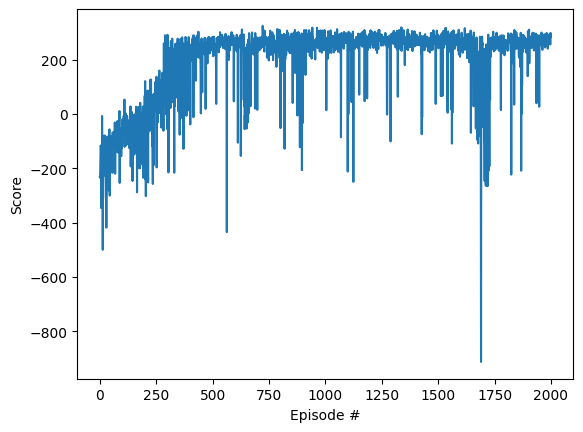

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Loss

Text(0, 0.5, 'Loss')

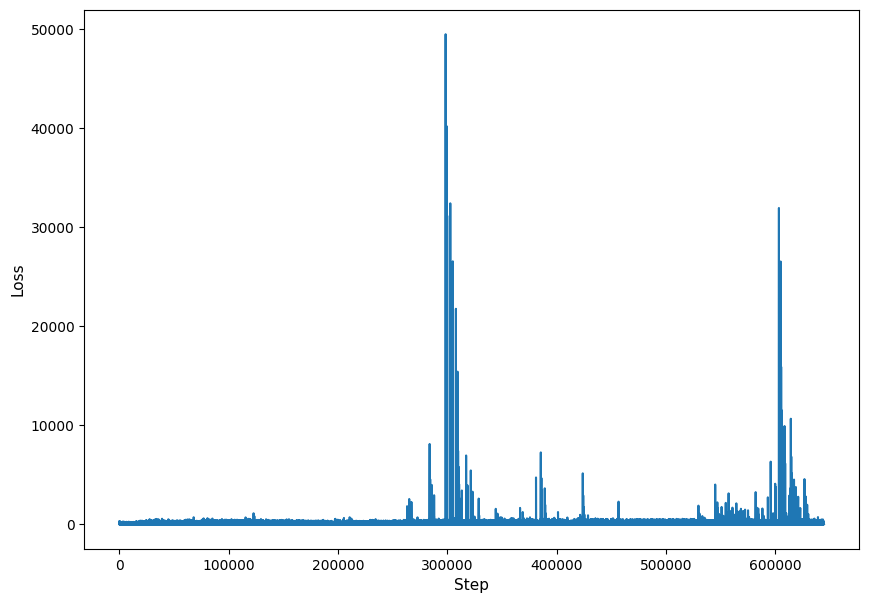

In [10]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Step", fontsize=11)
plt.ylabel("Loss", fontsize=11)

Test Model

In [14]:
model.load_state_dict(torch.load('save.pt'))

for i in range(20):
    cur_state = env.reset()
    cur_state = torch.tensor(cur_state)

    for j in range(400):
        pred_Q = model(cur_state).data.numpy()
        action = np.argmax(pred_Q)

        env.render()
        state, reward, done, _ = env.step(action)
            
        if done:
            break
            
env.close()